In [1]:
import os
import json
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr


In [2]:
load_dotenv()
openai_api_key = os.getenv('OPENAI_API_KEY')
anthropic_api_key = os.getenv('ANTHROPIC_API_KEY')
MODEL= 'gpt-4o-mini'

In [3]:
if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set")
    
if anthropic_api_key:
    print(f"Anthropic API Key exists and begins {anthropic_api_key[:7]}")
else:
    print("Anthropic API Key not set")

OpenAI API Key exists and begins sk-proj-
Anthropic API Key exists and begins sk-ant-


In [4]:
openai = OpenAI()


In [5]:
import base64
from io import BytesIO
from PIL import Image

In [6]:
system_message = "You are a helpful assistant for an Airline called FlightAI. "
system_message += "Give short, courteous answers, no more than 1 sentence. "
system_message += "Always be accurate. If you don't know the answer, say so."
    

In [7]:
# def chat(message, history):
#     messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
#     response = openai.chat.completions.create(model=MODEL, messages=messages)
#     return response.choices[0].message.content

# gr.ChatInterface(fn=chat, type="messages").launch()


In [8]:
ticket_prices = {
    "london": "$799",
    "paris": "$899",
    "tokyo": "$1400",
    "berlin": "$499",
    "new_york": "$650",
    "los_angeles": "$750",
    "sydney": "$1600",
    "dubai": "$1200",
    "rome": "$850",
    "singapore": "$1300",
    "toronto": "$700",
    "bangkok": "$1100",
    "madrid": "$780",
    "hong_kong": "$1250",
    "amsterdam": "$820",
    "istanbul": "$950",
    "seoul": "$1350",
    "cairo": "$880",
    "rio_de_janeiro": "$980",
    "cape_town": "$1450",
    "beijing": "$1380",
    "mexico_city": "$900",
    "buenos_aires": "$1050",
    "moscow": "$1200",
    "vienna": "$830",
    "lisbon": "$810",
    "são_paulo": "$1020",
    "prague": "$790",
    "stockholm": "$860",
    "helsinki": "$870",
    "oslo": "$890",
    "budapest": "$740",
    "warsaw": "$720",
    "brussels": "$805",
    "zurich": "$880",
    "geneva": "$895",
    "athens": "$910",
    "jakarta": "$1250",
    "manila": "$1220",
    "kuala_lumpur": "$1180",
    "taipei": "$1280",
    "ho_chi_minh_city": "$1120",
    "hanoi": "$1110",
    "mumbai": "$1150",
    "delhi": "$1170",
    "bangalore": "$1190",
    "chennai": "$1160",
    "santiago": "$1080",
    "bogota": "$980",
    "lima": "$970",
    "auckland": "$1650",
    "nairobi": "$1320",
    "lagos": "$1400",
    "doha": "$1250",
    "riyadh": "$1275"
}

In [9]:
def get_ticket_price(destination_city):
    print(f"Tool get_ticket_price called for {destination_city}")
    city = destination_city.lower()
    return ticket_prices.get(city, "Unknown")

In [10]:
# There's a particular dictionary structure that's required to describe our function:

price_function = {
    "name": "get_ticket_price",
    "description": "Get the price of a return ticket to the destination city. Call this whenever you need to know the ticket price, for example when a customer asks 'How much is a ticket to this city'",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city that the customer wants to travel to",
            },
        },
        "required": ["destination_city"],
        "additionalProperties": False
    }
}

In [11]:
tools = [{"type": "function", "function": price_function}]

In [12]:
# def chat(message, history):
#     messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
#     response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

#     if response.choices[0].finish_reason=="tool_calls":
#         message = response.choices[0].message
#         response, city = handle_tool_call(message)
#         messages.append(message)
#         messages.append(response)
#         response = openai.chat.completions.create(model=MODEL, messages=messages)
    
#     return response.choices[0].message.content

In [13]:
def handle_tool_call(message):
    tool_call = message.tool_calls[0]
    arguments = json.loads(tool_call.function.arguments)
    city = arguments.get('destination_city')
    price = get_ticket_price(city)
    response = {
        "role": "tool",
        "content": json.dumps({"destination_city": city,"price": price}),
        "tool_call_id": tool_call.id
    }
    return response, city

In [14]:
def artist(city):
    image_response = openai.images.generate(
        model='dall-e-3',
        prompt=f"An image representing a vacation in {city}, showing tourist spots and everything unique about {city}, in a vibrant pop-art style",
            size="1024x1024",
            n=1,
            response_format="b64_json",
        )
    
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

In [15]:
image = artist('Tehran')

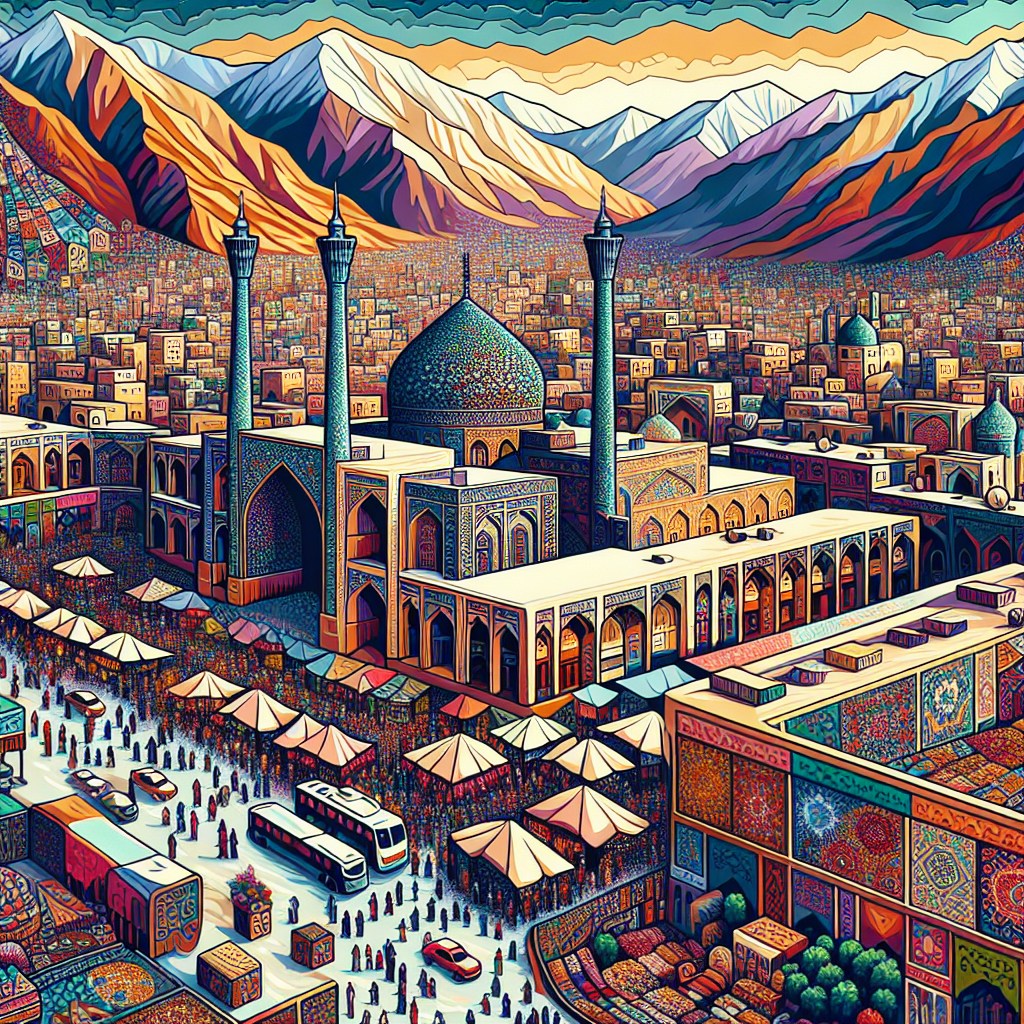

In [16]:
display(image)

In [20]:
from pydub import AudioSegment
from pydub.playback import play

def talker(message):
    response = openai.audio.speech.create(
      model="tts-1",
      voice="onyx",    # Also, try replacing onyx with alloy
      input=message
    )
    
    audio_stream = BytesIO(response.content)
    audio = AudioSegment.from_file(audio_stream, format="mp3")
    play(audio)

In [21]:
talker('how are you')

Input #0, wav, from '/var/folders/v9/yz64p8z5579c6d6yx28446qh0000gn/T/tmp0dxheb8e.wav':
  Duration: 00:00:00.74, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s


In [22]:
def chat(message,history):
    messages = [{"role": "system", "content": system_message}] + history +  [{"role":"user", "content":message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)
    image = None

    if response.choices[0].finish_reason == 'tool_calls':
        message  = response.choices[0].message
        response,city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        image = artist(city)

        response = openai.chat.completions.create(model=MODEL, messages=messages)
    reply = response.choices[0].message.content
    history += [{"role":"assistant", "content":reply}]
    talker(reply)

    return history,image,""


In [23]:
with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500 , type='messages')
        image_output = gr.Image(height=500)

    with gr.Row():
        entry = gr.Textbox(label = 'chat with AI')
        with gr.Row():
            clear = gr.Button('clear')
        entry.submit(chat, [entry, chatbot], [chatbot, image_output,entry])

        clear.click(lambda: None, inputs=None, outputs=chatbot, queue=False)
ui.launch()


* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Tool get_ticket_price called for Montreal


Input #0, wav, from '/var/folders/v9/yz64p8z5579c6d6yx28446qh0000gn/T/tmplvjvymj6.wav':
  Duration: 00:00:04.51, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s



Tool get_ticket_price called for Toronto


Input #0, wav, from '/var/folders/v9/yz64p8z5579c6d6yx28446qh0000gn/T/tmpwmceejrn.wav':
  Duration: 00:00:02.88, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s


# First PROTOTYPE

In [24]:
gpt_system = "You are a helpful AI assistant working for a travel agency. \
You assist customers with booking tickets, checking prices, and providing travel information. \
You should provide accurate, up-to-date details about flights, hotels, and transportation options. \
Your goal is to help the customer plan their trip smoothly. The conversation will be done in 8 back-and-forth exchanges."

claude_system = "You are a curious customer who wants to travel and gather information. \
You are looking for ticket prices, available flights, and recommendations for your trip. \
You ask detailed questions about different destinations, travel options, and costs. \
Your goal is to get the best travel advice possible. The conversation will be done in 8 back-and-forth exchanges."

gpt_messages = ["Hello! How can I assist you with your travel plans today?"]
claude_messages = ["Hi! I'm looking to travel soon and need some details about flights."]